In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import lmfit
import scipy as sp

In [2]:
lib = ctypes.CDLL("./getspec.dll", winmode=0)

In [3]:
c_floating = ctypes.c_double;

In [4]:
class c_cfloating(ctypes.Structure): 
    """complex is a c structure
    https://docs.python.org/3/library/ctypes.html#module-ctypes suggests
    to use ctypes.Structure to pass structures (and, therefore, complex)
    """
    _fields_ = [("real", c_floating),("imag", c_floating)]
    @property
    def value(self):
        return self.real+1j*self.imag # fields declared above

In [5]:
c_floating_ptr = ctypes.POINTER(c_floating)
c_cfloating_ptr = ctypes.POINTER(c_cfloating)
c_uint_ptr = ctypes.POINTER(ctypes.c_uint)
c_int = ctypes.c_int

In [6]:
lib.reserve_complex_array.restype = c_cfloating_ptr
lib.reserve_complex_array.argtypes = [ctypes.c_int]
lib.reserve_array.restype = c_floating_ptr
lib.reserve_array.argtypes = [ctypes.c_int]
lib.reserve_twists.restype = c_cfloating_ptr
lib.reserve_twists.argtypes = [ctypes.c_int]
lib.reserve_bitrev.restype = c_uint_ptr
lib.reserve_bitrev.argtypes = [ctypes.c_int]

lib.free_array.restype = None
lib.free_array.argtypes = [c_floating_ptr]
lib.free_complex_array.restype = None
lib.free_complex_array.argtypes = [c_cfloating_ptr]
lib.free_uint_array.restype = None
lib.free_uint_array.argtypes = [c_uint_ptr]


lib.sdeeval.restype = ctypes.c_bool
lib.sdeeval.argtypes = [c_floating_ptr, c_floating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr,
                        c_cfloating_ptr, c_uint_ptr, c_int, c_int, c_int, c_int, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating]

In [7]:
Npow = 16; 
L = 2**Npow;  # number of examined dots

# initialize arrays
twist = lib.reserve_twists(Npow)
bitrev = lib.reserve_bitrev(Npow)
Ex = lib.reserve_complex_array(L)
Ey = lib.reserve_complex_array(L)
tmpEx = lib.reserve_complex_array(L)
tmpEy = lib.reserve_complex_array(L)
specx = lib.reserve_array(L)
specy = lib.reserve_array(L)

In [8]:
# interesting parametres (equal spikes)
alpha = 6.;
kappa = 680.;
gamma = 1.;
gamma_d = 6000.;
gamma_a =  1.7;
gamma_p = 2*np.pi*30;
beta = -0.2;
mu = 23.;
C_sp = 5e-5;
N_th = 6.25e6;
N_th = 1
N_tr = 5.935e6;
N_tr = 0.7*N_th
N_rel = N_tr / N_th

Dt = 1e-6;
tau = 1e-4;
offset = 0.2;
Nav = 3;

In [9]:
alpha = 6.;
kappa = 680.;
gamma = 1.;
gamma_d = 6000.;
gamma_a =  1.72;
gamma_p = 2*np.pi*30;
beta = -0.2;
mu = 23.;

C_sp = 5e-5;
N_th = 6.25e6;
N_th = 1
N_tr = 5.935e6;
N_tr = 0.7*N_th
N_rel = N_tr / N_th

Dt = 1e-6;
tau = 1e-4;
offset = 0.2;
Nav = 3;

tauDt = round(np.floor(tau/Dt));
if tauDt < 1:
    tauDt = 1
tau = tauDt * Dt;  # fix tau in order to make it right value

skip = round(offset * L);  # how many dots will be skipped by offset

freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)
fstep = freqs[1]-freqs[0]

In [248]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt, 
            alpha, kappa, gamma, gamma_d, gamma_a, 
            gamma_p, beta, mu, C_sp, N_rel);
    

CPU times: total: 3.62 s
Wall time: 4.44 s


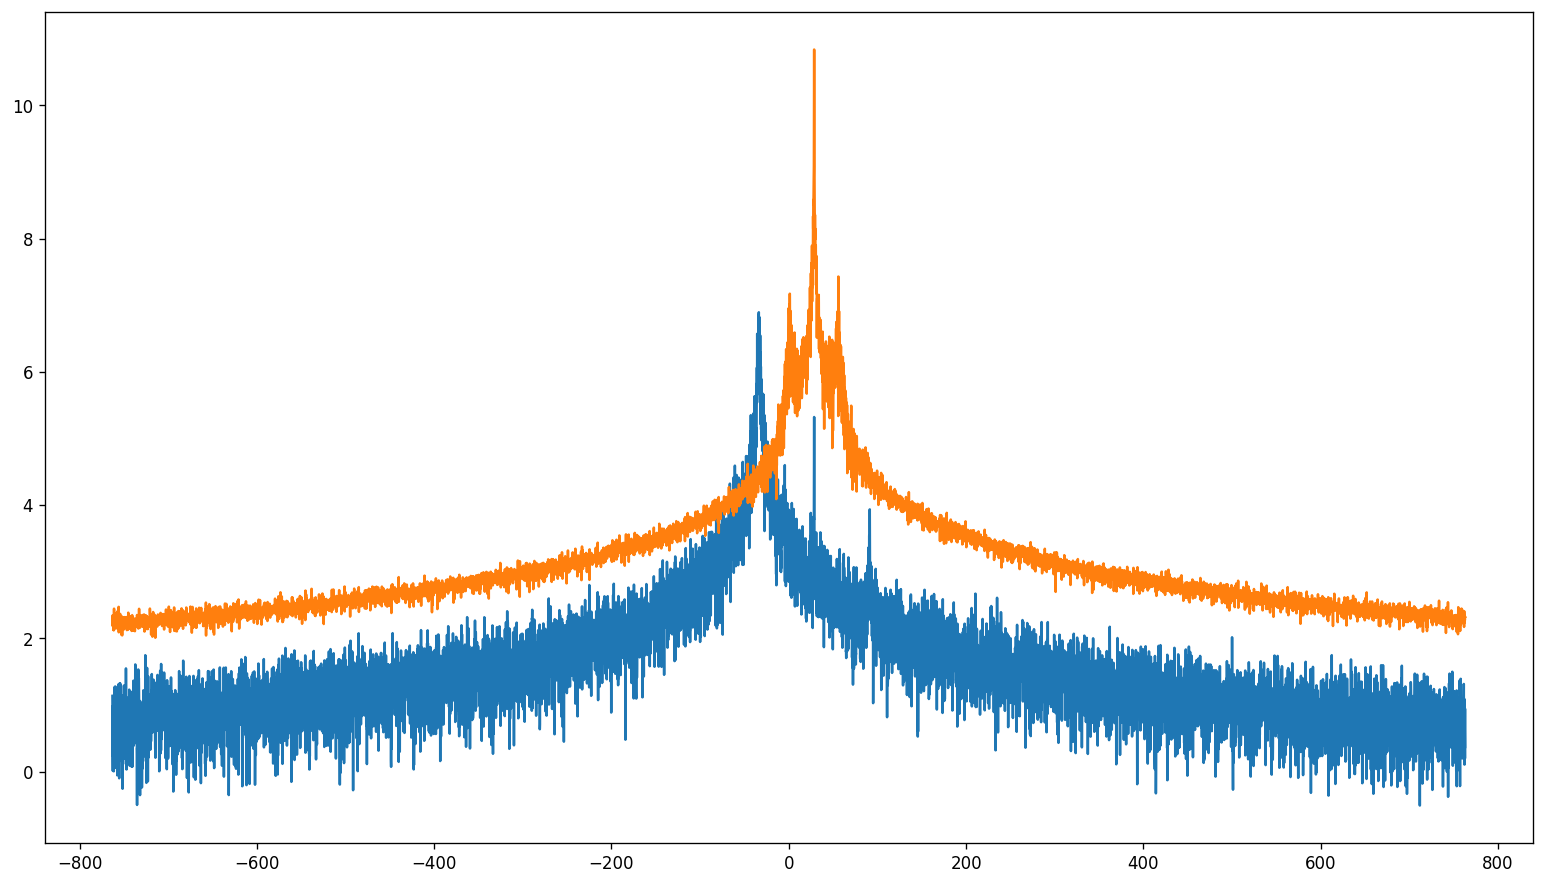

In [249]:
plt.figure(figsize=(16,9), dpi=120)
WW = 5000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spx[wnd]), freqs[wnd], np.log10(spy[wnd]))
plt.show()

In [28]:
pars = {'alpha': 3.0000000458257627,
 'kappa': 80.00000000000173,
 'gamma_d': 1000.0000000000031,
 'gamma_a': 2.500000000000008,
 'gamma_p': 56.548667764617086,
 'beta': 3.552713678800501e-15,
 'mutilde': 3.57653791130186,
 'mu': 42.55706308551398,
 'C_sp': 5.000000000000002e-05,
 'N_rel': 0.9380000000000002}

In [21]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, 10, tauDt, Dt, 
            pars['alpha'], pars['kappa'], 1.0, pars['gamma_d'], pars['gamma_a'], 
            pars['gamma_p'], pars['beta'], pars['mu'], pars['C_sp'], pars['N_rel']);

CPU times: total: 19.8 s
Wall time: 25.4 s


In [22]:
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

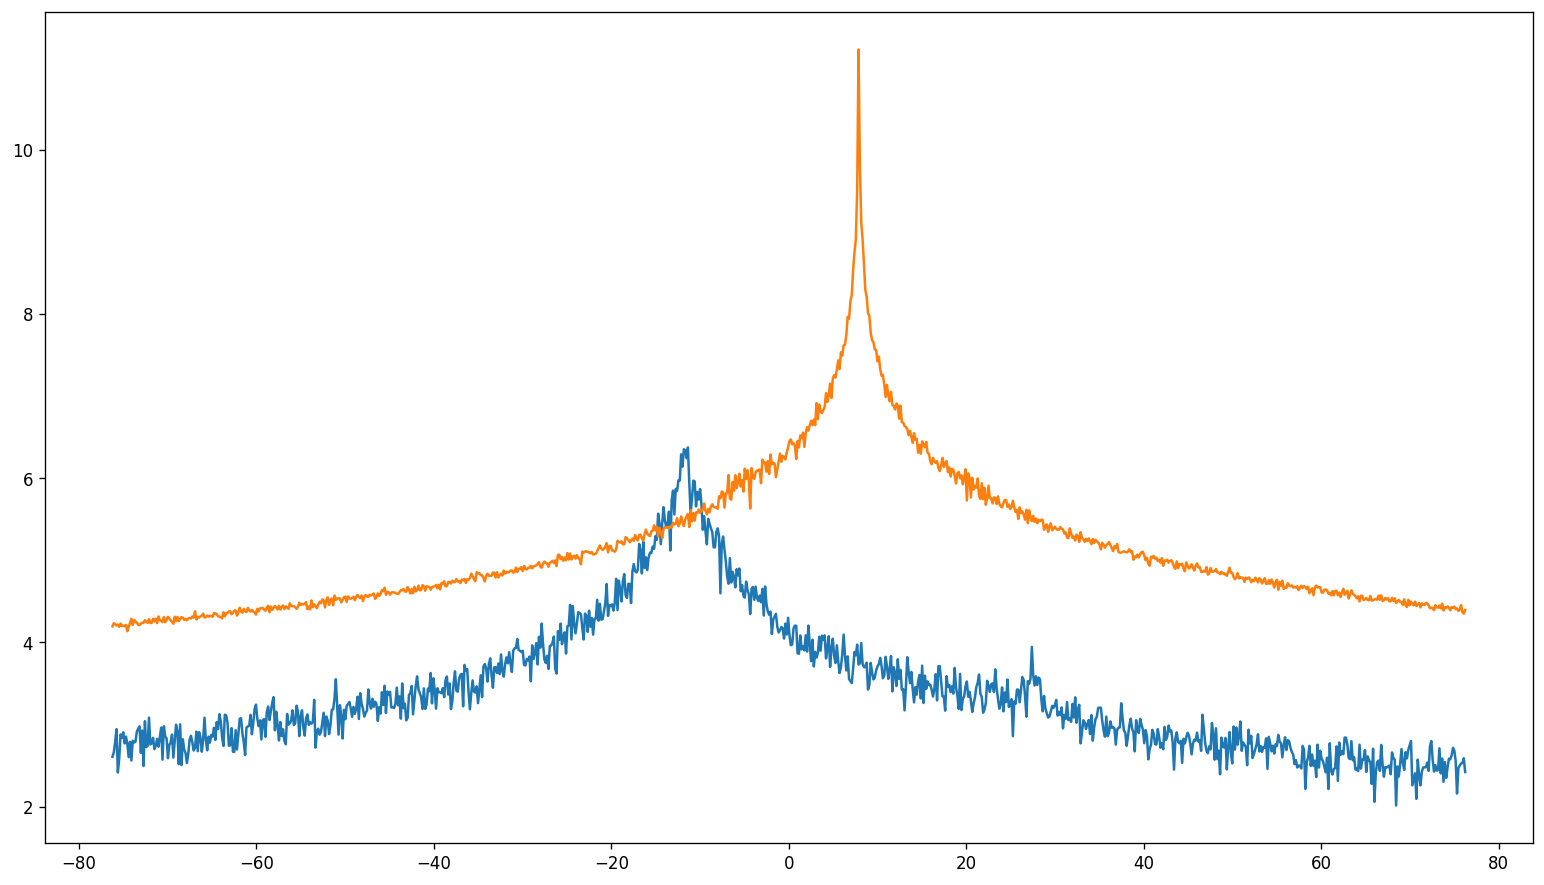

In [23]:
plt.figure(figsize=(16,9), dpi=120)
WW = 500
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spx[wnd]), freqs[wnd], np.log10(spy[wnd]))
plt.show()

In [258]:
sigma = 7.9015451 / fstep
spxf = sp.ndimage.gaussian_filter1d(spx, sigma, mode="constant", cval=0.0)
spyf = sp.ndimage.gaussian_filter1d(spy, sigma, mode="constant", cval=0.0)

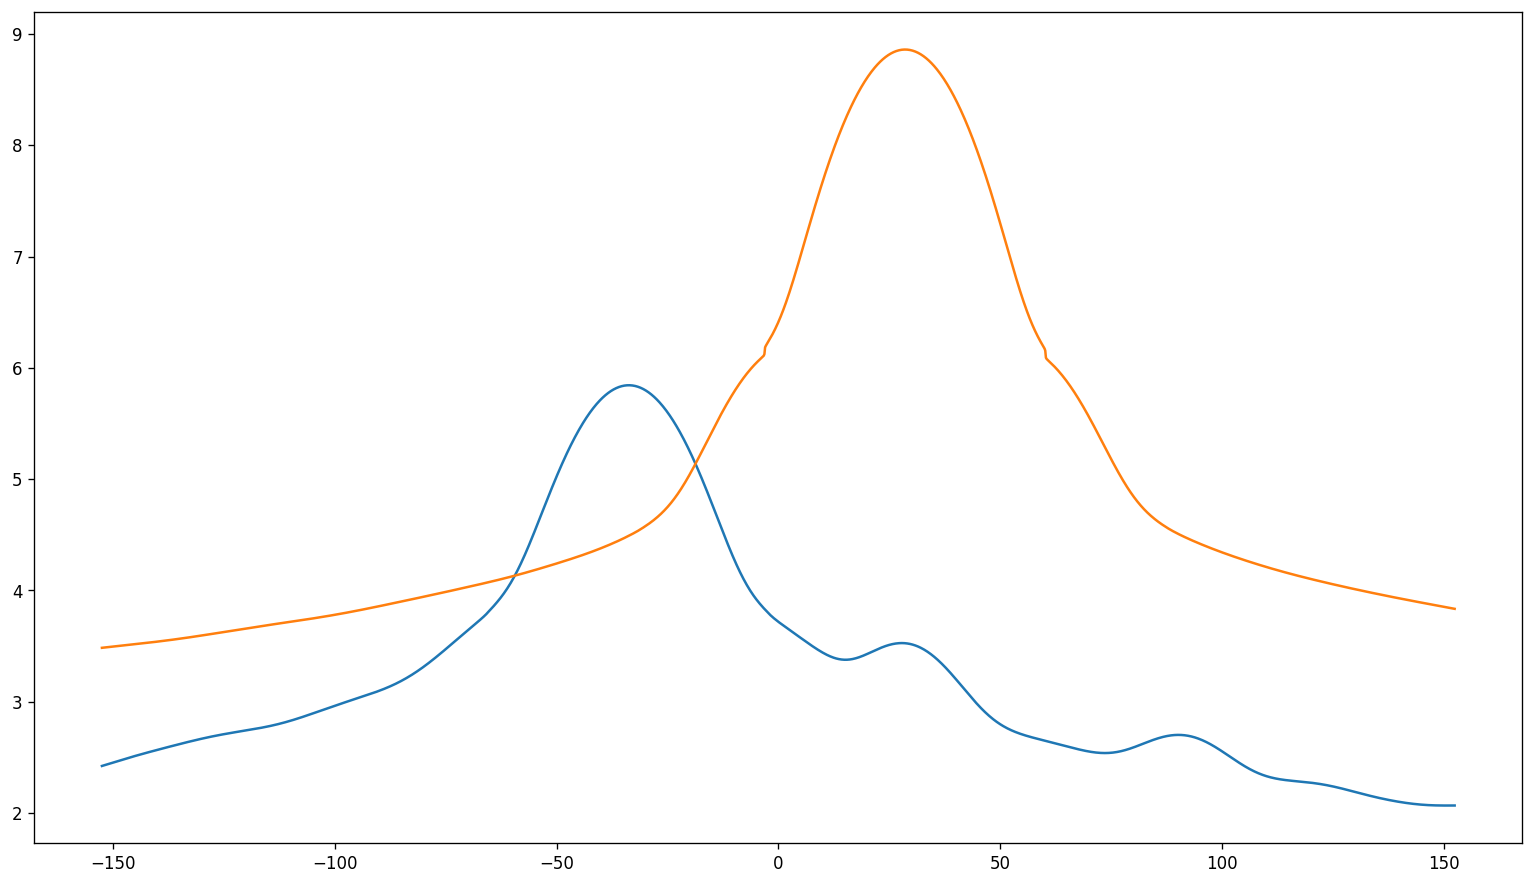

In [259]:
plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spxf[wnd]), freqs[wnd], np.log10(spyf[wnd]))
plt.show()

In [13]:
pars = {'alpha': 8.459689837908757,
 'kappa': 420.74434119698077,
 'gamma_d': 1754.0577428695992,
 'gamma_a': 99.1165417163582,
 'gamma_p': 1220.0123080538688,
 'beta': -3.1258367372397484,
 'mutilde': 3.57653791130186,
 'mu': 4.0085814827868695,
 'C_sp': 1.737463682029687e-05,
 'N_rel': 0.14360374613646987}

In [19]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, 3, tauDt, Dt, 
            pars['alpha'], pars['kappa'], 1.0, pars['gamma_d'], pars['gamma_a'], 
            pars['gamma_p'], pars['beta'], pars['mu'], pars['C_sp'], pars['N_rel']);

CPU times: total: 6.27 s
Wall time: 8.09 s


In [15]:
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

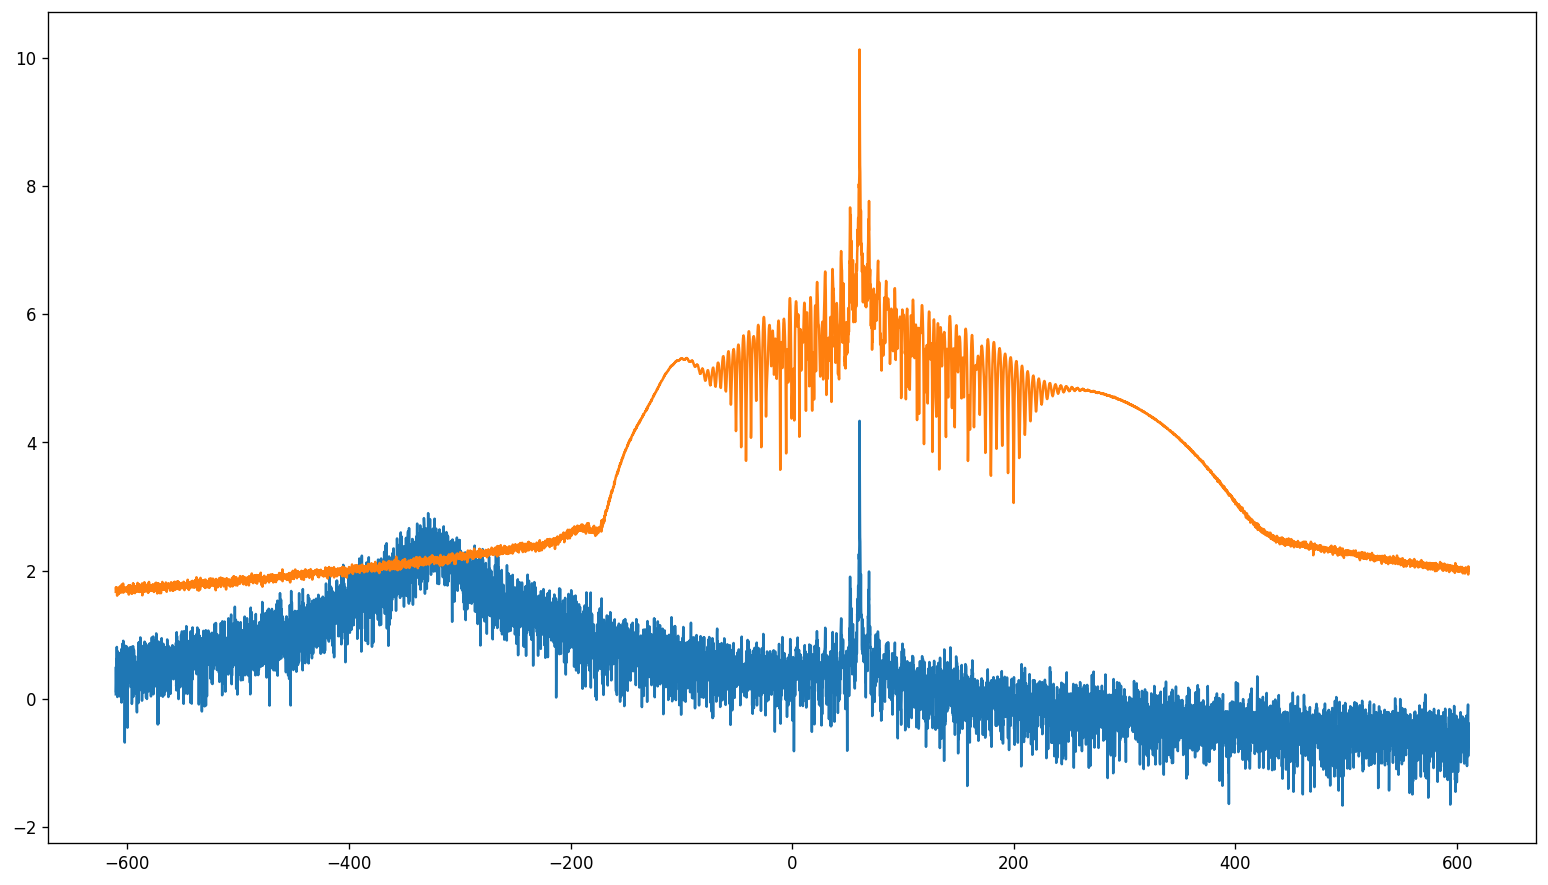

In [20]:
plt.figure(figsize=(16,9), dpi=120)
WW = 4000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spx[wnd]), freqs[wnd], np.log10(spy[wnd]))
plt.show()

In [13]:
sigma = 0.75 / fstep
spxf = sp.ndimage.gaussian_filter1d(spx, sigma, mode="constant", cval=0.0)
spyf = sp.ndimage.gaussian_filter1d(spy, sigma, mode="constant", cval=0.0)

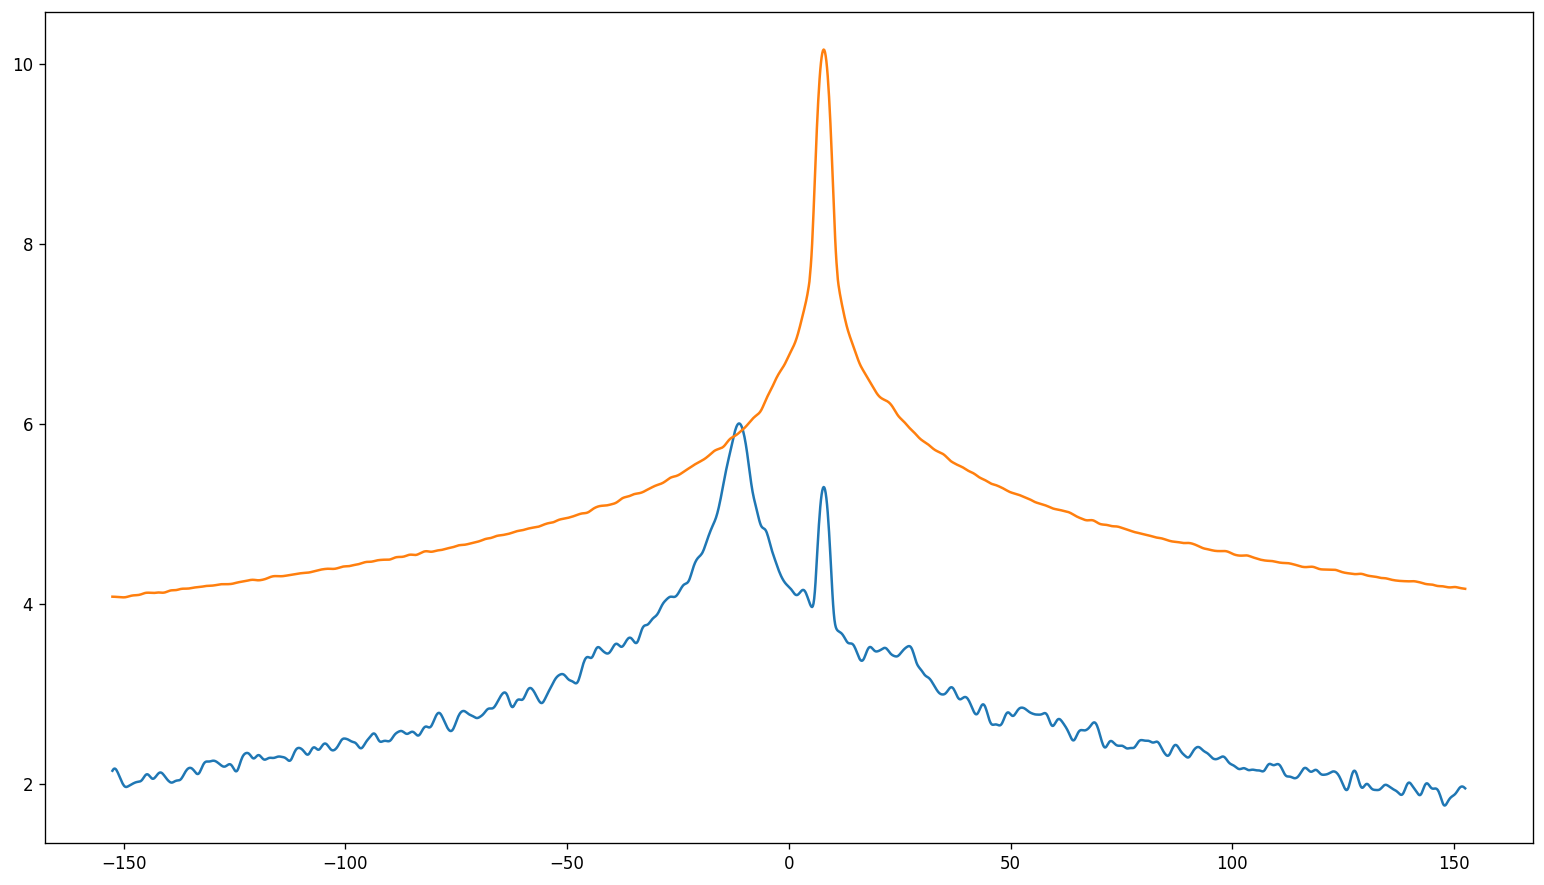

In [15]:
plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spxf[wnd]), freqs[wnd], np.log10(spyf[wnd]))
plt.show()

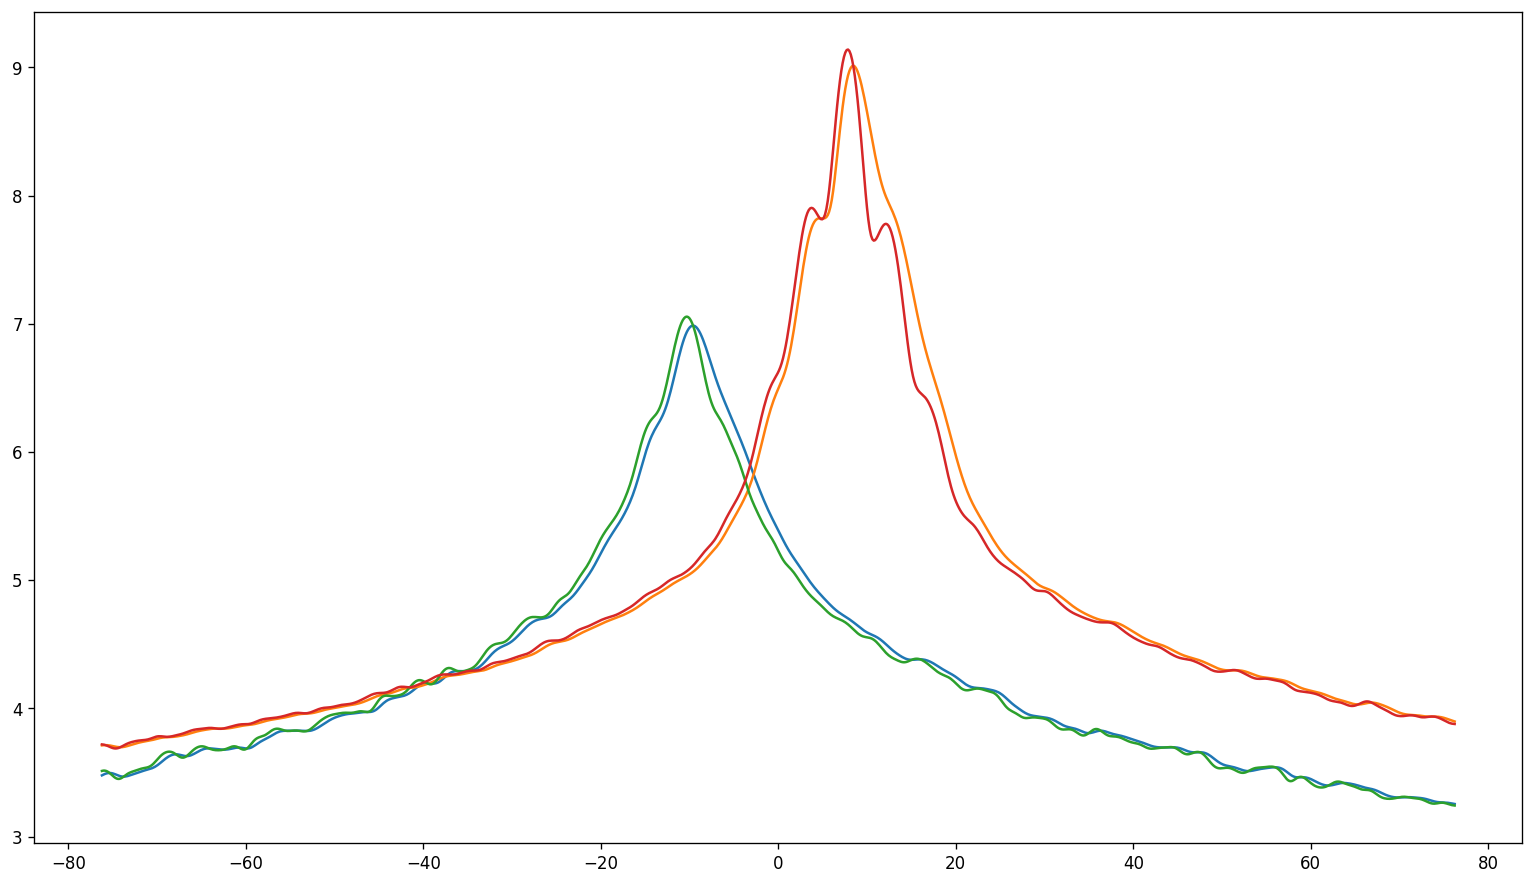

In [75]:
savx = spxf
savy = spyf
b, a = sp.signal.butter(1, 0.05);
savx2 = sp.signal.lfilter(b, a, spxf)
savy2 = sp.signal.lfilter(b, a, spyf)
savx[spxf < 5.] = savx2[spxf < 5.]
savy[spyf < 5.] = savy2[spyf < 5.]
plt.figure(figsize=(16,9), dpi=120)
WW = 500
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(savx2[wnd]), freqs[wnd], np.log10(savy2[wnd]))
plt.plot(freqs[wnd], np.log10(spxf[wnd]), freqs[wnd], np.log10(spyf[wnd]))
plt.show()

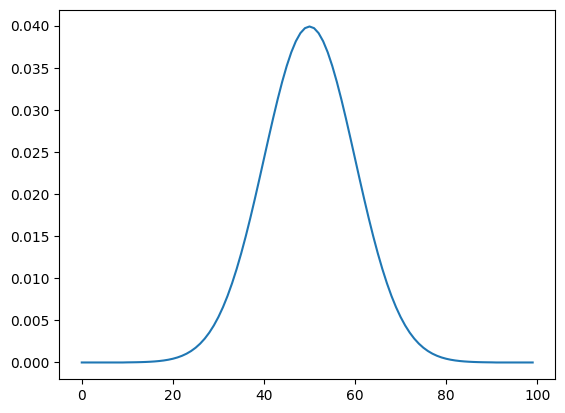

In [45]:
zz = np.zeros(100)
zz[50] = 1.;
plt.plot(sp.ndimage.gaussian_filter1d(zz, 10., mode="constant", cval=0.0))

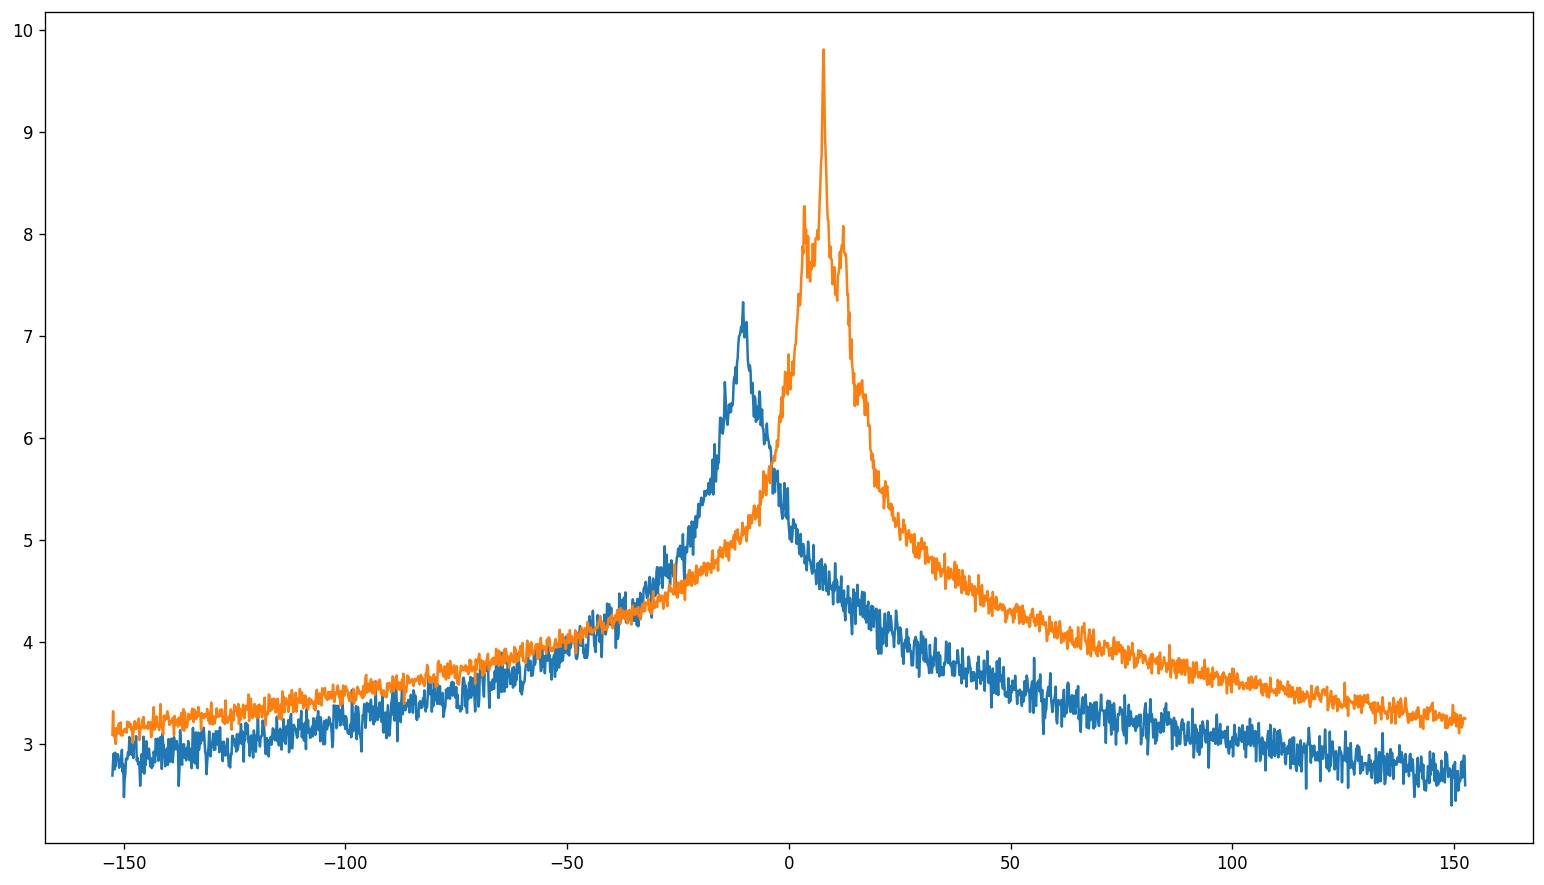

In [43]:
freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)

plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spx[wnd]), freqs[wnd], np.log10(spy[wnd]))
plt.show()

In [13]:
# free all memory
lib.free_complex_array(Ex)
lib.free_complex_array(Ey)
lib.free_complex_array(tmpEx)
lib.free_complex_array(tmpEy)
lib.free_complex_array(twist)
lib.free_array(specx)
lib.free_array(specy)
lib.free_uint_array(bitrev)

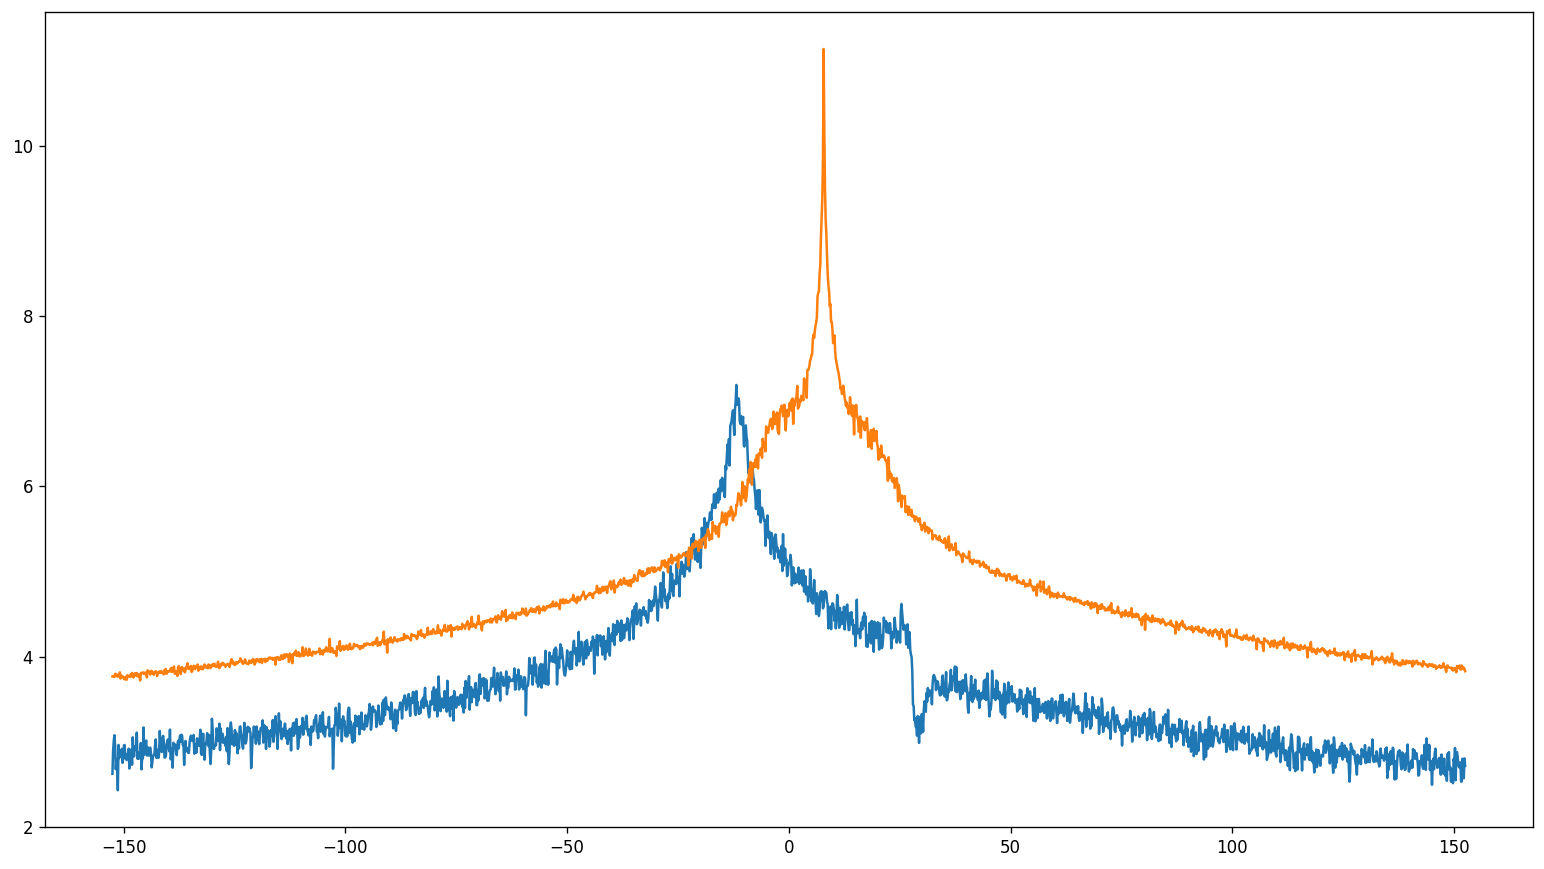

In [21]:
freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)

plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(spx[wnd]), freqs[wnd], np.log10(spy[wnd]))
plt.show()

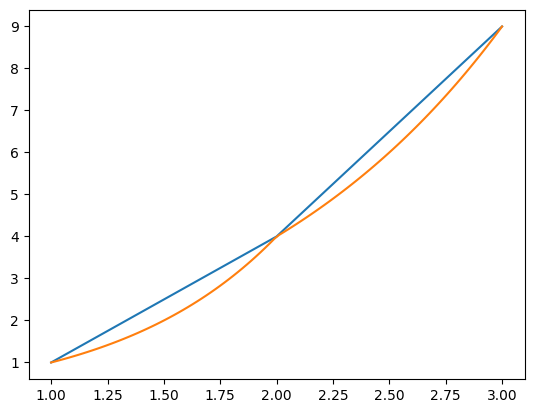

In [95]:
x = np.linspace(1.,3.,3)
y = x**2
x2 = np.linspace(1., 3., 100)
f = sp.interpolate.interp1d(x, np.log10(y))
y2 = f(x2)
plt.plot(x, y, x2, 10**(y2))

In [97]:
a = np.arange(5)
b = np.arange(5)*0.1
np.reshape([a,b], -1)

array([0. , 1. , 2. , 3. , 4. , 0. , 0.1, 0.2, 0.3, 0.4])

In [ ]:
np.ctypeslib.as_array(ptrtw, )

In [2]:
data = np.loadtxt("SDEsolution.txt")

ValueError: x and y must have same first dimension, but have shapes (100000,) and (0,)

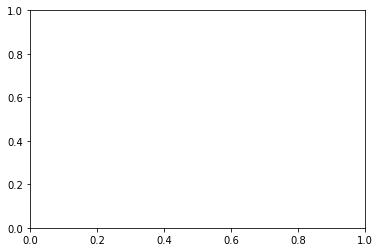

In [3]:
tau = 1e-4
Twnd = 10.
T = np.arange(0, Twnd, tau)
chunksz = round(Twnd/tau)
stch = 4
plt.plot(T, data[(chunksz*stch):(chunksz*(stch+1)),0], T, data[(chunksz*stch):(chunksz*(stch+1)),1])

In [7]:
Ep = np.sqrt(data[:, 0]) * np.exp(1j*(data[:,2] + data[:,3]))
Em = np.sqrt(data[:, 1]) * np.exp(1j*(data[:,2] - data[:,3]))
Ex = (Ep + Em) / np.sqrt(2)
Ey = (Ep - Em) / np.sqrt(2) / 1j

In [8]:
specsx = []
specsy = []
for i in range(1):
    specsx.append(np.abs(np.fft.fftshift(np.fft.fft(Ex[round(0.2*chunksz*i):round(0.2*chunksz*i)+chunksz])))**2)
    specsy.append(np.abs(np.fft.fftshift(np.fft.fft(Ey[round(0.2*chunksz*i):round(0.2*chunksz*i)+chunksz])))**2)
powspecx = np.mean(specsx, axis=0)
powspecy = np.mean(specsy, axis=0)

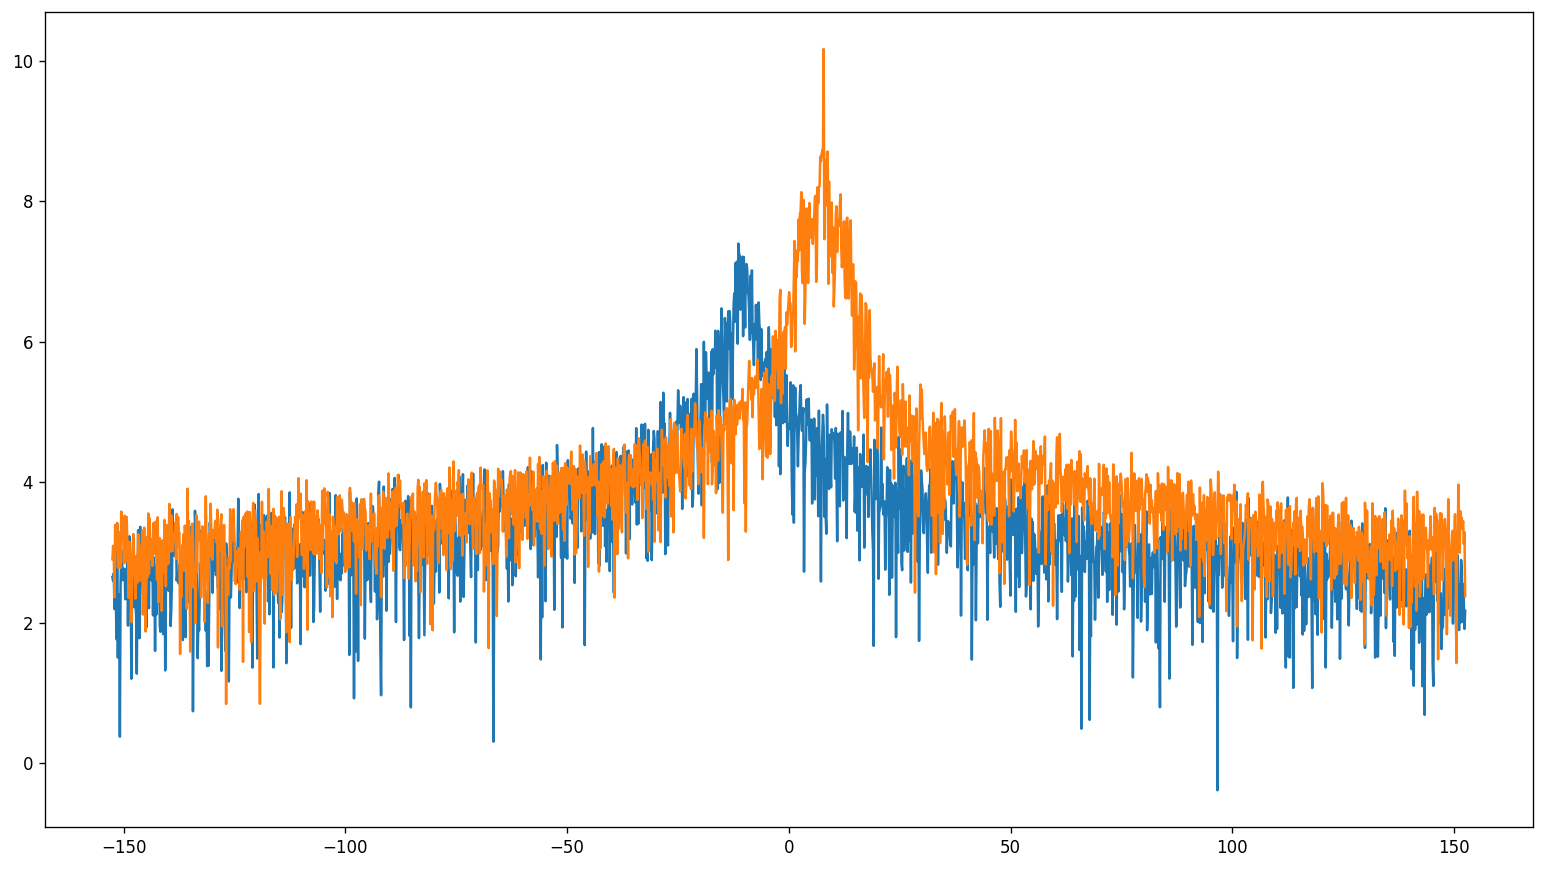

In [9]:
freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)

plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(powspecx[wnd]), freqs[wnd], np.log10(powspecy[wnd]))
plt.show()

In [10]:
np.savetxt("pytonSpec.txt", np.transpose([freqs, powspecx, powspecy]))

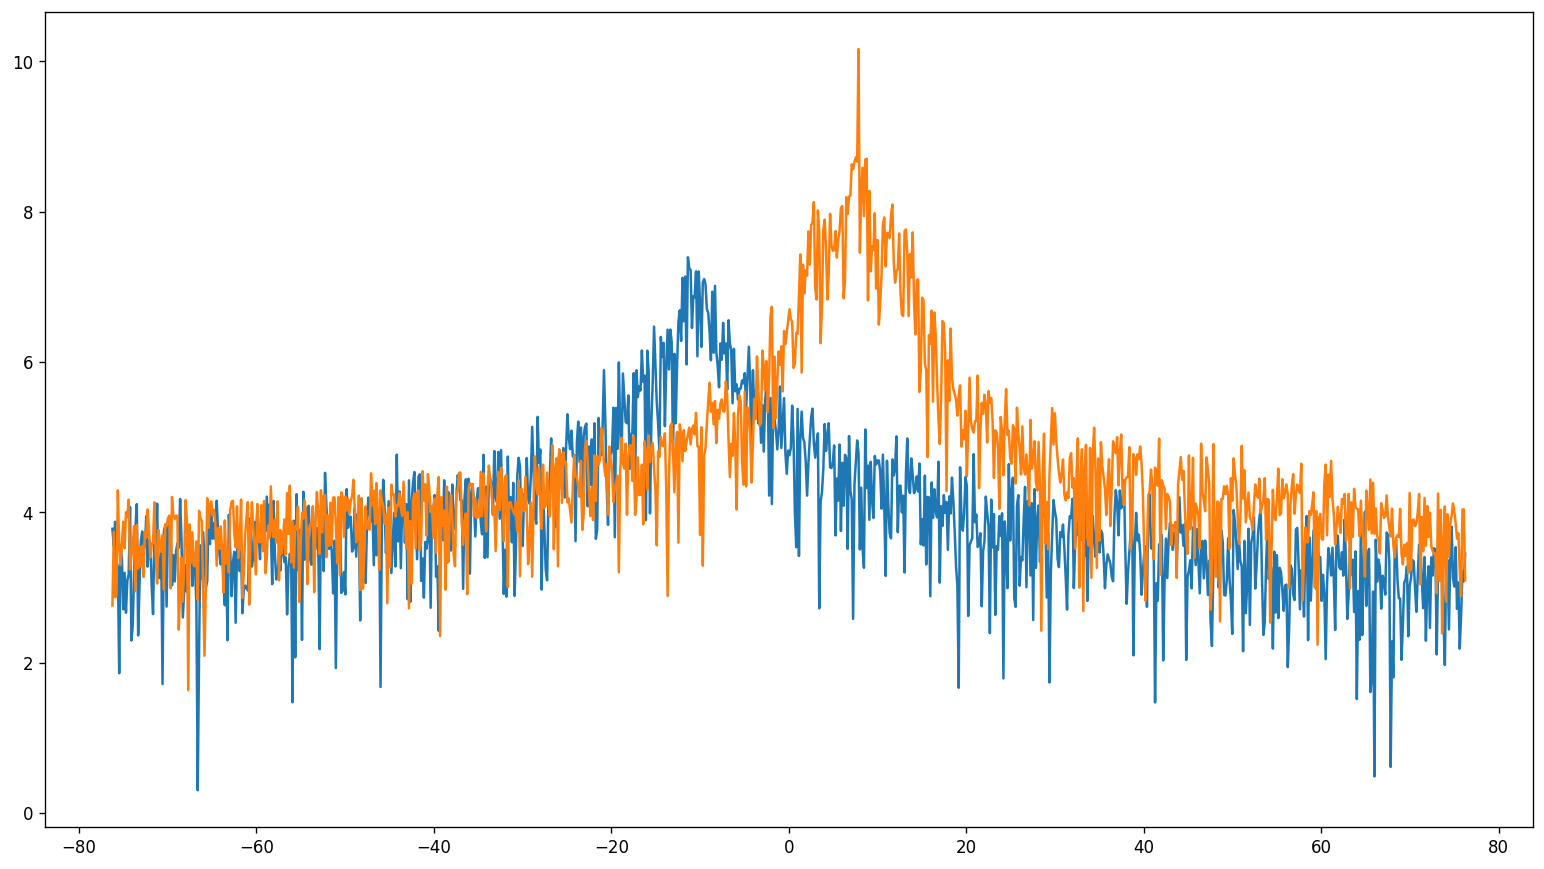

In [14]:
freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)

plt.figure(figsize=(16,9), dpi=120)
WW = 500
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(powspecx[wnd]), freqs[wnd], np.log10(powspecy[wnd]))
plt.show()

In [57]:
specs = np.loadtxt("SDEspec.txt")

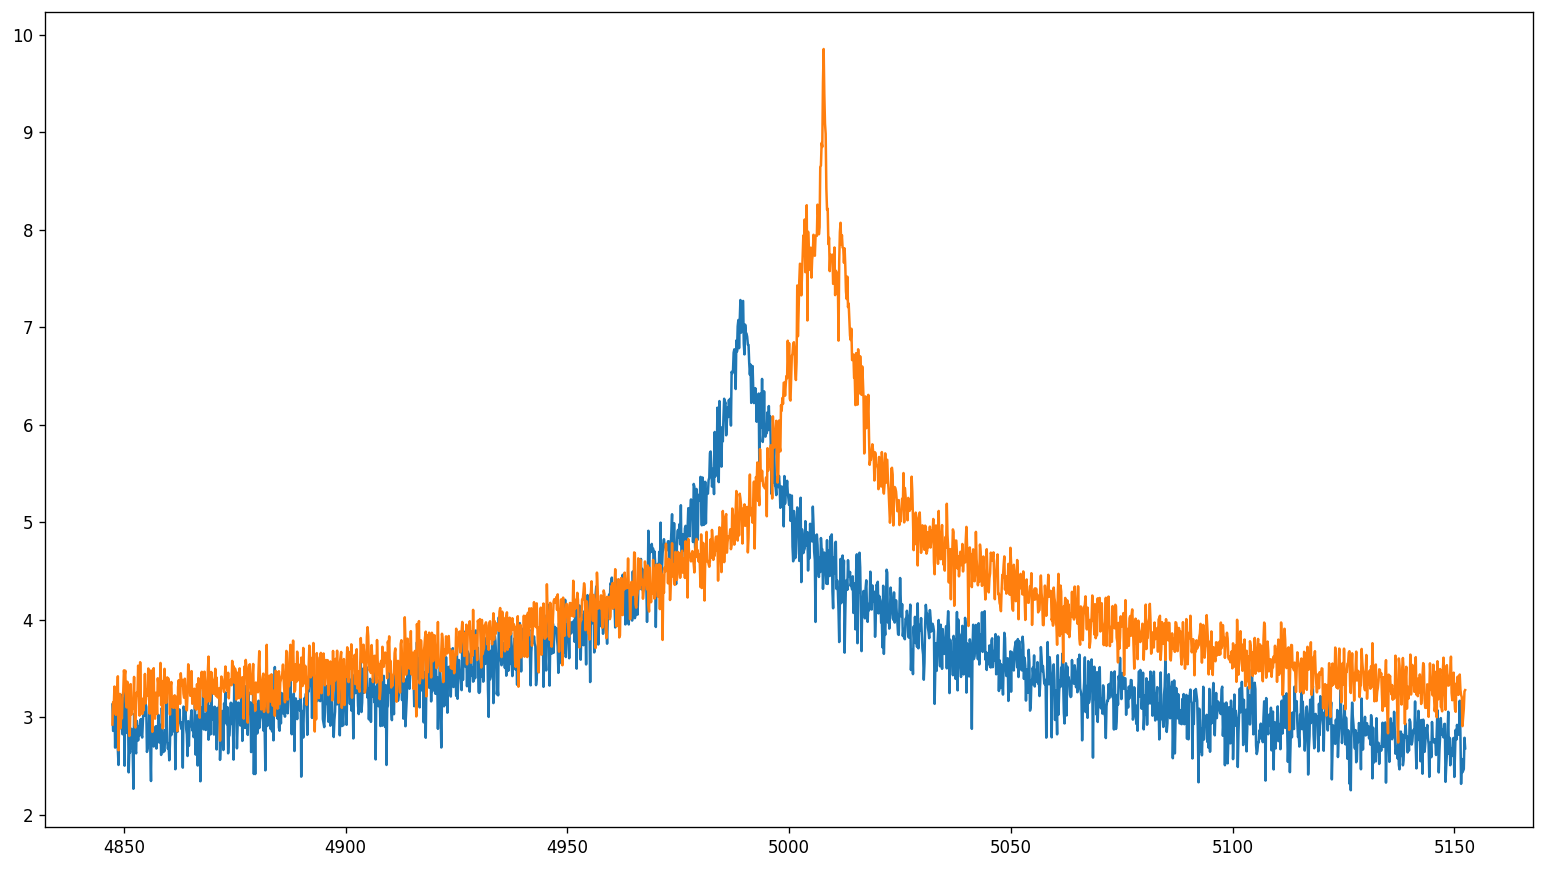

In [60]:
freqs = 1/2**16/tau * np.arange(2**16);
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.figure(figsize=(16,9), dpi=120)
plt.plot(freqs[wnd], np.log10(specs[wnd,0]), freqs[wnd], np.log10(specs[wnd,1]))
plt.show()

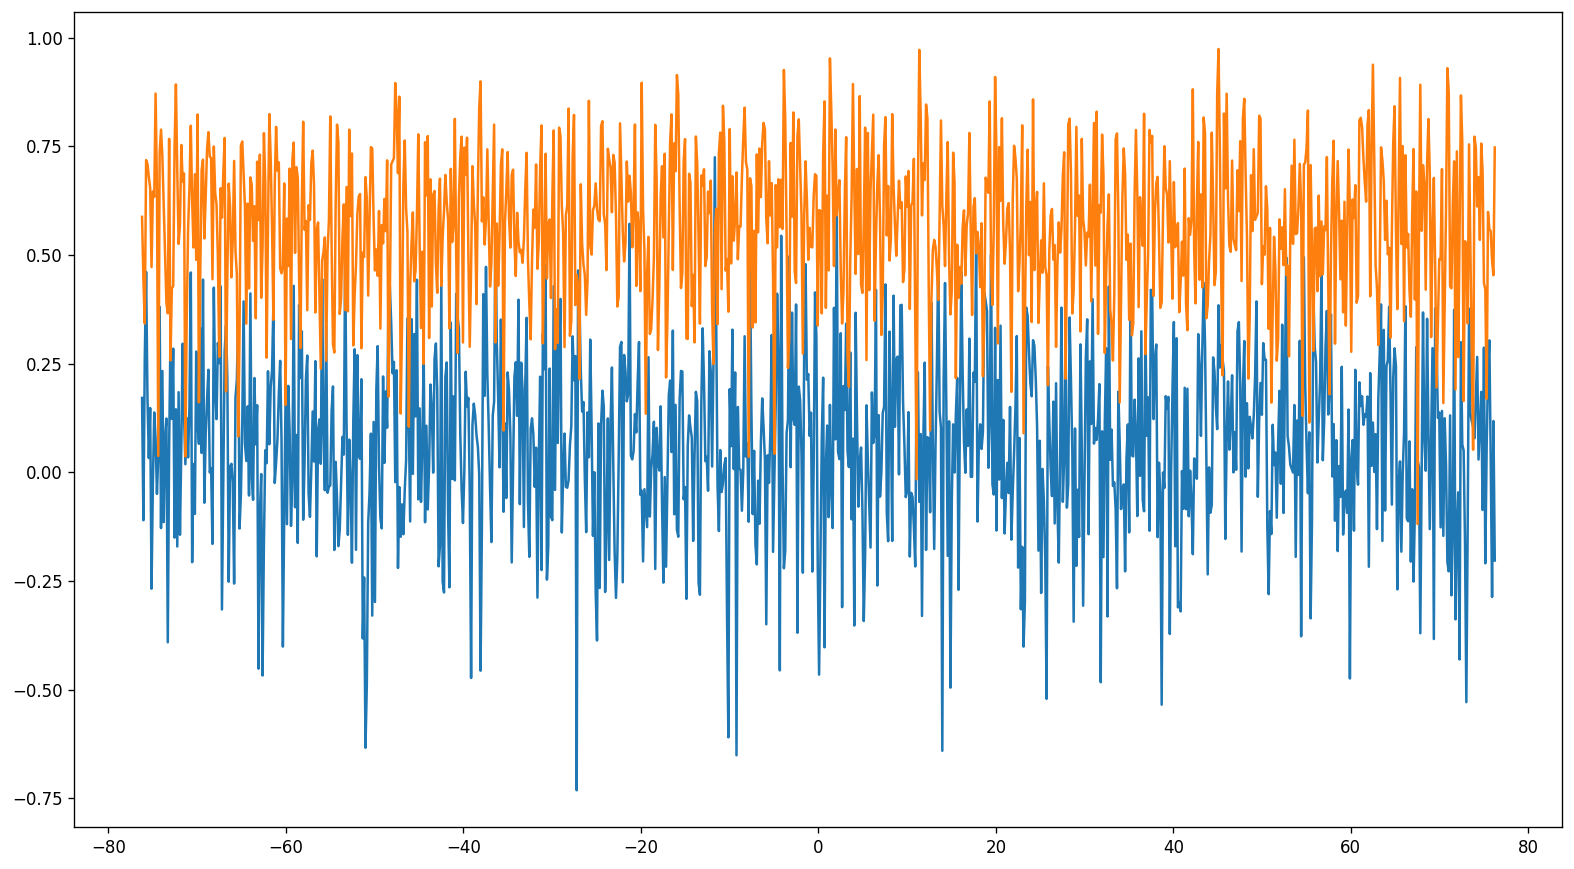

In [63]:
freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)
WW = 500
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.figure(figsize=(16,9), dpi=120)
plt.plot(freqs[wnd], np.log10(np.fft.fftshift(specs[:,0])[wnd]), freqs[wnd], np.log10(np.fft.fftshift(specs[:,1])[wnd]))
plt.show()

In [39]:
np.fft.fftshift(ff)[2**15]

0.0

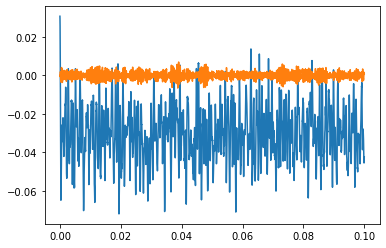

In [18]:
plt.plot(T, data[:,4]-1,T, data[:,5])

In [9]:
N = 1000000
smpl = 2*np.random.random(N)-1
smpl2 = 2*np.random.random(N)-1
R = np.sum(smpl2) / np.sqrt(N/3)
sqsum = np.sum(smpl**2)
out = smpl/np.sqrt(sqsum) * R

(array([ 99891., 100159.,  99896.,  99422., 100143.,  99862., 100359.,
         99734., 100372., 100162.]),
 array([-2.87735421e-03, -2.30188320e-03, -1.72641218e-03, -1.15094116e-03,
        -5.75470142e-04,  8.76311278e-10,  5.75471894e-04,  1.15094291e-03,
         1.72641393e-03,  2.30188495e-03,  2.87735597e-03]),
 <BarContainer object of 10 artists>)

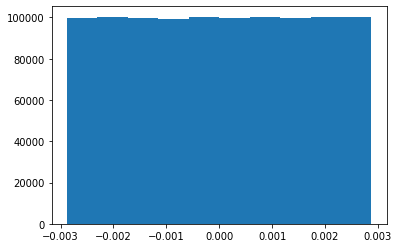

In [24]:
plt.hist(out)

In [22]:
R

1.8610702304524358

In [17]:
stattest = np.loadtxt("SDErandom.txt")

In [18]:
stattest.shape

(10000000, 4)

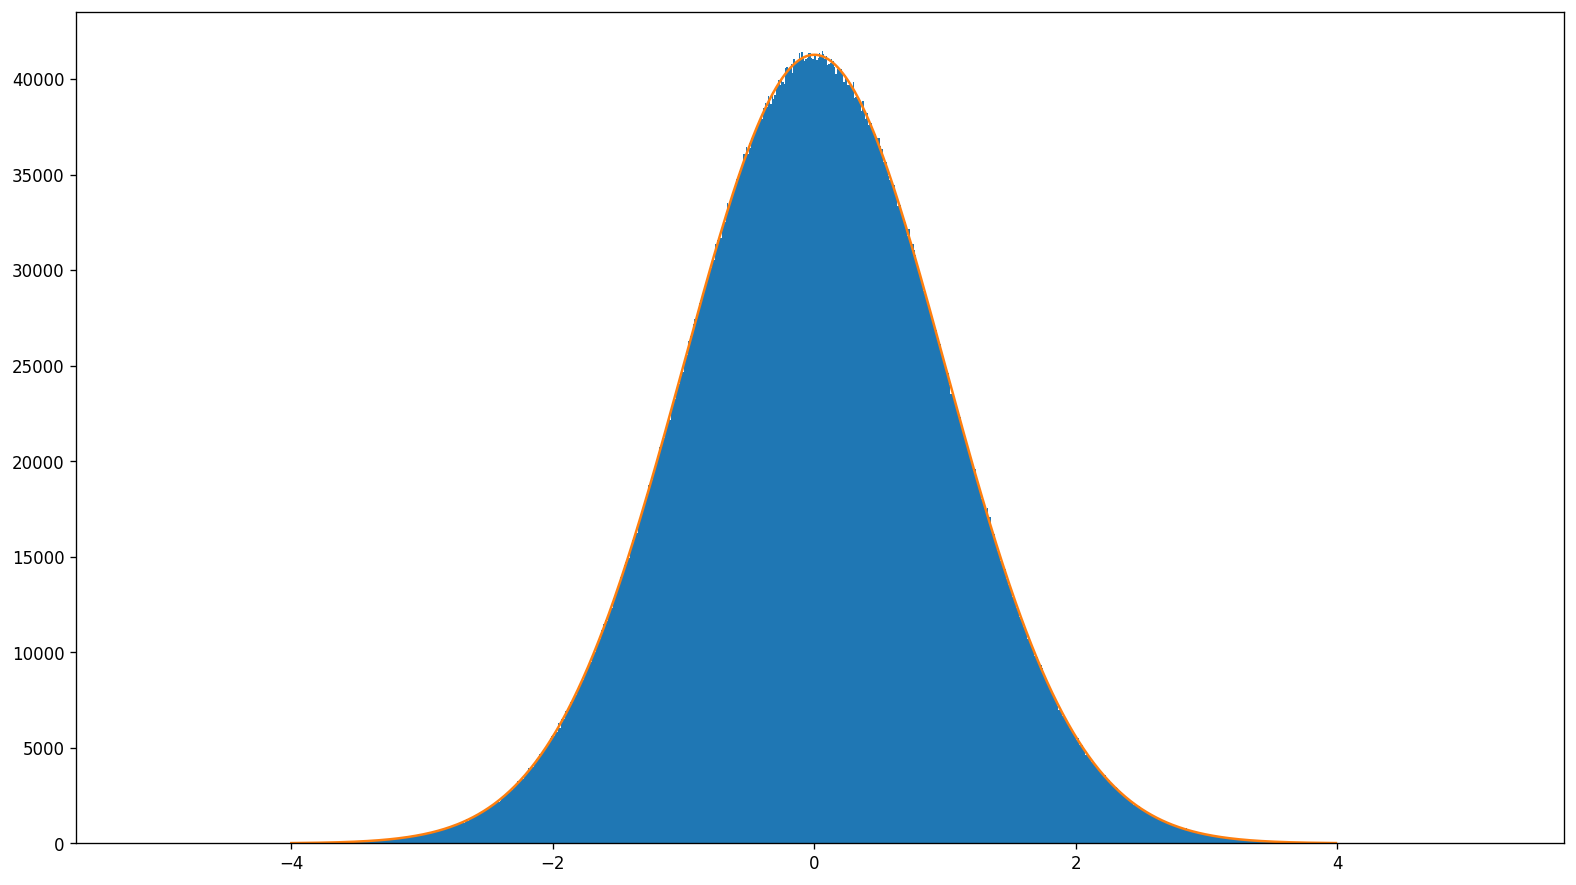

In [21]:
plt.figure(figsize=(16,9), dpi=120)
a,b,_ = plt.hist(stattest[:,2], bins=1000)
x = np.arange(-4., 4., 0.01)
y = stattest.shape[0]*(b[1]-b[0])/np.sqrt(np.pi*2)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

In [4]:
corr = np.correlate(stattest[0:10000], stattest[0:10000],"same")

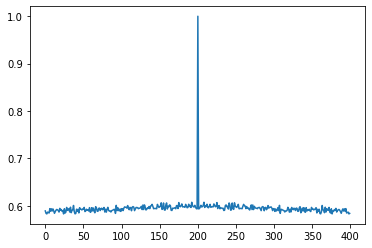

In [8]:
plt.plot(corr[4800:5200]/np.max(corr))

In [38]:
arr = [1, 2, 1, 2, 1, 2, 1, 2]
arr = np.arange(1,17)
np.fft.fft(arr)

array([136. +0.j        ,  -8.+40.21871594j,  -8.+19.3137085j ,
        -8.+11.9728461j ,  -8. +8.j        ,  -8. +5.3454291j ,
        -8. +3.3137085j ,  -8. +1.59129894j,  -8. +0.j        ,
        -8. -1.59129894j,  -8. -3.3137085j ,  -8. -5.3454291j ,
        -8. -8.j        ,  -8.-11.9728461j ,  -8.-19.3137085j ,
        -8.-40.21871594j])